# Implementando makemore con MLPs

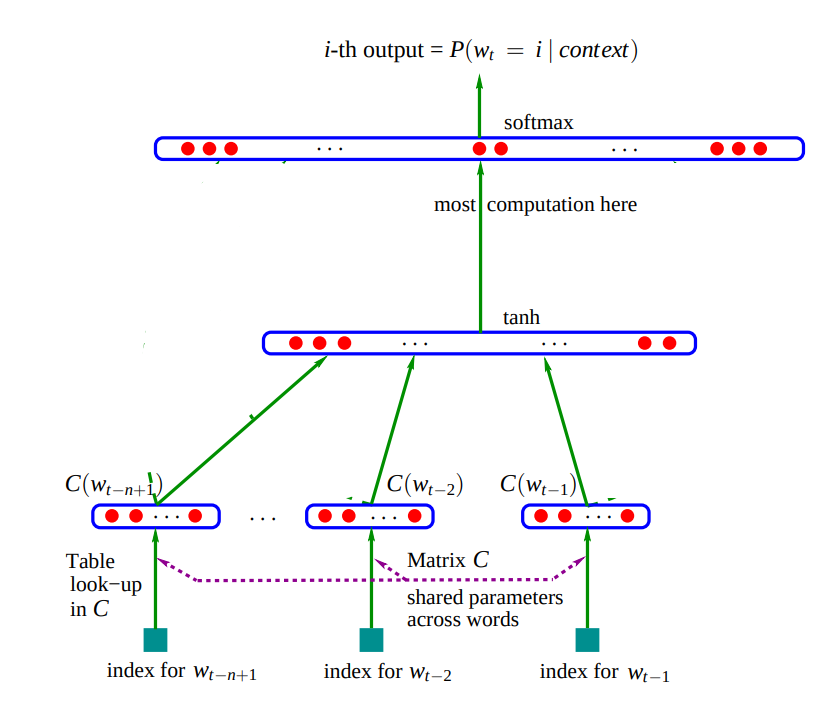

https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
import idna

# def utf8_to_punycode(text: str) -> str:
#     """Encodes a UTF-8 string to its Punycode representation."""
#     return idna.encode(text).decode('ascii')

def punyencode(text: str) -> str:
    """Encodes a UTF-8 string to its Punycode representation, handling spaces by encoding each word separately."""
    
    return " ".join([idna.encode(word).decode('ascii') for word in text.split()])
    
def punydecode(punycode: str) -> str:
    """Decodes a Punycode string back to UTF-8."""
    #return idna.decode(punycode)
    return " ".join([idna.decode(word) for word in punycode.split()])

def process_name(name):
    name = name.lower()
    for n in name.split():
        if len(n) < 2:
            return ''
    try:
        return punyencode(name)
    except:
        #print(f'Cant convert {name}')
        return ''

dataset = open("data/city_names_full.txt", 'r').read().split('\n')
with open('data/city_names_puny.txt', 'w') as f:
    for n in dataset:
        name = process_name(n)
        if name != '':
            f.write(name+'\n')
dataset = open("data/city_names_puny.txt", 'r').read().split('\n')
puny = [x for x in dataset if 'xn--' in x]
nopuny = [x for x in dataset if 'xn--' not in x]
np.random.seed(42)
dataset = [x.item() for x in np.random.choice(nopuny, 100000,replace=False)]

# Construyendo el dataset para Makemore con MLPs

In [ ]:
print(len(dataset))
charset = ['*'] + sorted(list(set([y for x in dataset for y in x])))
ctoi = {c:i for i, c in enumerate(charset)}
itoc = {i:c for i, c in enumerate(charset)}
charset_size = len(charset)


## La red neuronal
La red que vamos a implementar es similar a la de este paper. La principal diferencia es que vamos a implementar el modelo de lenguaje a nivel de caracteres en lugar a a nivel de palabras como en el paper.

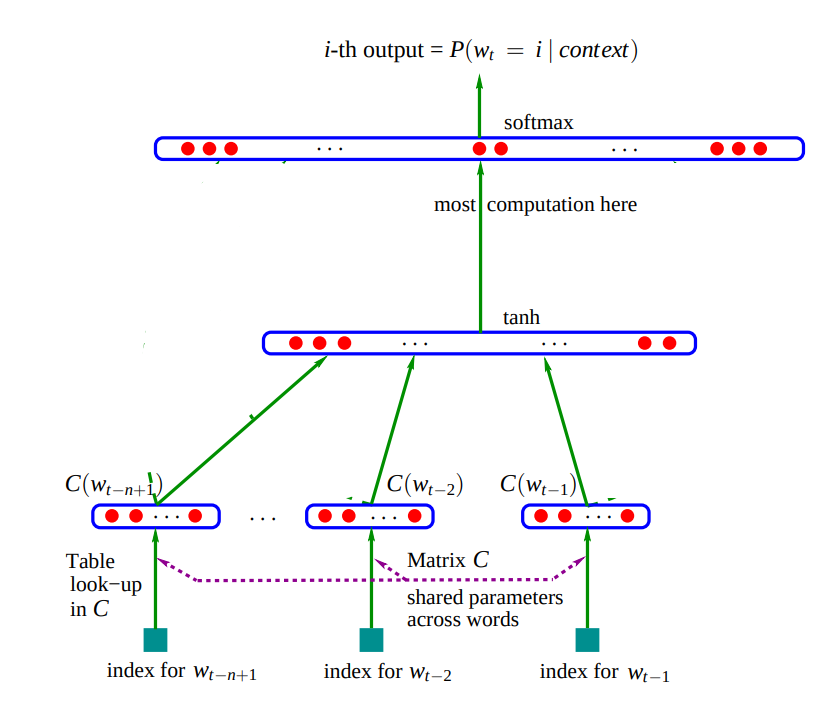

https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

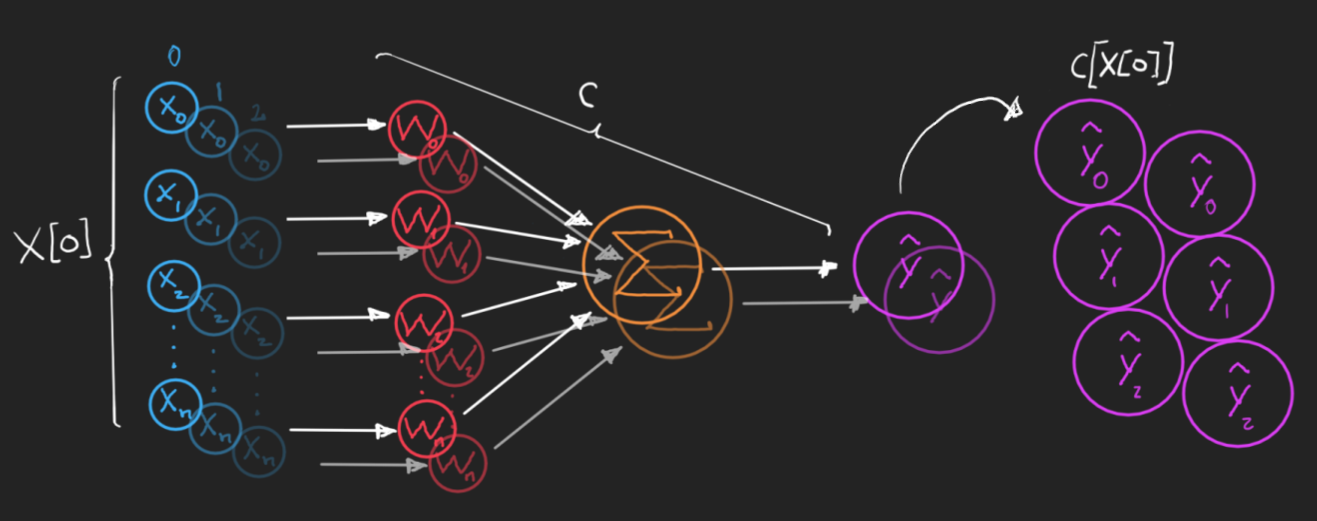

### Importante!
* El tamaño contexto de nuestro modelo (cuántos caracteres se utilizan para predecir la distribución de probabilidad del siguiente) determina muchas cosas y es conveniente tener claro cual es este número. En nuestro ejemplo, el tamaño del contexto es 3. Es decir, utilizamos 3 caracteres para predecir el siguiente.
* La matriz C puede interpretarse como la primer capa de perceptronoes.
    * C tiene 2 perceptrones de 40 entradas, es decir tiene 40 entradas y 2 salidas, lo que permite codificar 1 caracter en 2 dimensiones
    * Nuestro modelo no recibe como entrada un one hot de 40 dimensiones, recibe el índice de 3 caracteres.
    * Codificar 3 caracteres requiere que multiplicar (3, 40) @ (40, 2) --> (3, 2), es decir, primero tenemos que calcular el one hot encoding de los 3 caracteres y despues multiplicar los one hot por C.
    * Durante el entrenamiento vamos a queres mandarle "batches" de 3 caracteres. Es decir, vamos a queres enviar varios grupos de 3 caracteres. Si el tamaño del grupo es de 13, como vimos en el ejemplo, podemos interpretar que nuestra capa C esta recibiendo 13 grupos de 3 caracteres encodeados en one hot cuya dimensión sería (13, 3, 40) y lo va a multiplicar por (40, 2), es decir (13, 3, 40) @ (40, 2) --> (13, 3, 2). La salida se puede interpretar como 13 grupos de 3 caracteres encodeados en 2 dimensiones (las dimensiones del embedding).
    * Se puede lograr el mismo efecto indexando C mediante el uso las ténicas avanzadas de indexing de PyTorch, en lugar de hacer operaciones con matrices (guiño, guiño).
    * En general las dimensiones del modelo van a ser de
        * Entrada: `(batch_size, context_size, (charset_size))`, charset_size será necesario si usamos one hot encondig, se puede obviar si usamos indexing.
        * Primer capa (Matriz de embeddings): `(charset_size, emb_size)`, es decir, una red de emb_size perceptrones (emb_size salidas), cada uno con charset_size entradas.
        * Salida: `(batch_size, context_size, emb_size)`
        * `(batch_size, context_size, (charset_size)) @ (charset_size, emb_size) --> (batch_size, context_size, emb_size)`
    * Es necesario tener presente el tamaño de la salida por que de eso depende el tamaño de la entrada de la siguiente capa.

## La capa oculta
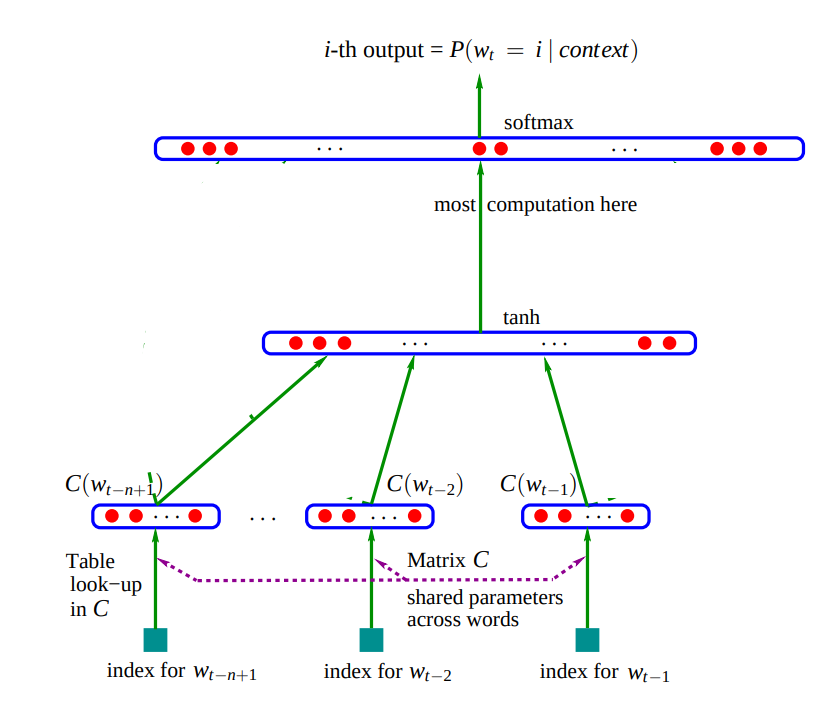

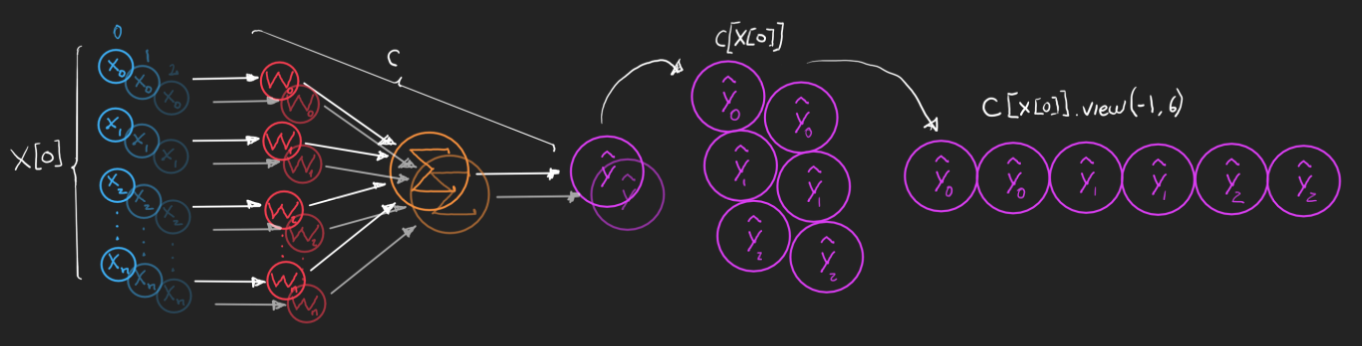

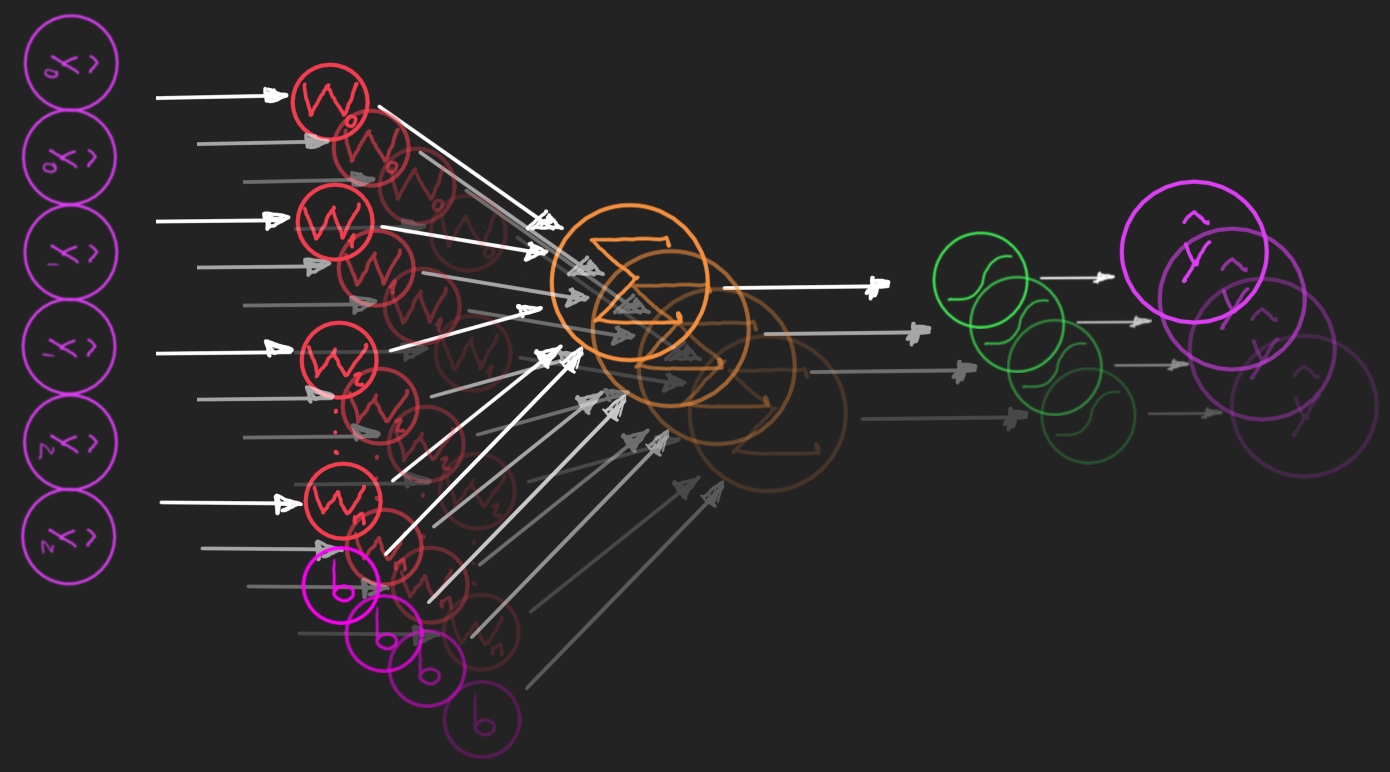

### Porque funciona esto? como se suma +b a todo eso y las reglas de broadcasting
De la documentación de PyTorch [Broadcasting rules](https://pytorch.org/docs/stable/notes/broadcasting.html)

*Two tensors are "broadcastable" if the following rules hold:*
* *Each tensor has at least one dimension.*
* *When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.*

# La capa de output
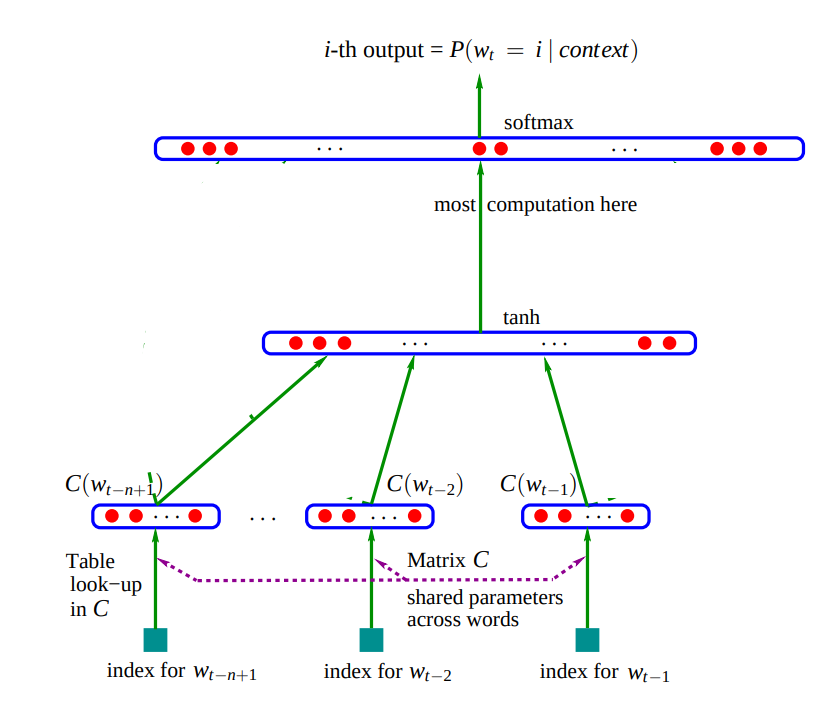

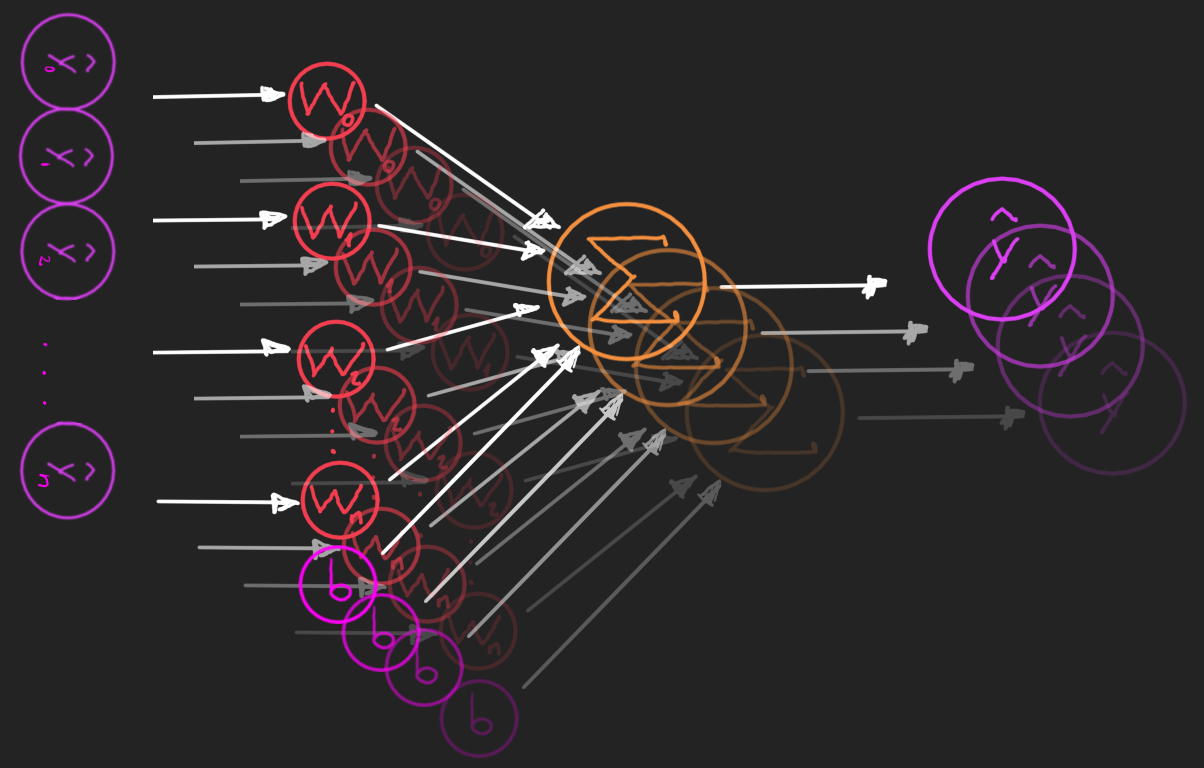

## Pasando todo en limpio

In [ ]:
context_size = 3  # El tamaño del contexto o cuantos caracteres vamos a usar para predecir el siguiente
X, Y = [], []

for d in dataset[:1]:
    #print(d)
    example = list(d) + ['*']
    context = [0] * context_size
    for c in example:
        #print(''.join([itoc[x] for x in context]) + ' --> ' + c)
        X.append(context)
        Y.append(ctoi[c])
        context = context[1:] + [ctoi[c]]
X = torch.tensor(X)
Y = torch.tensor(Y)

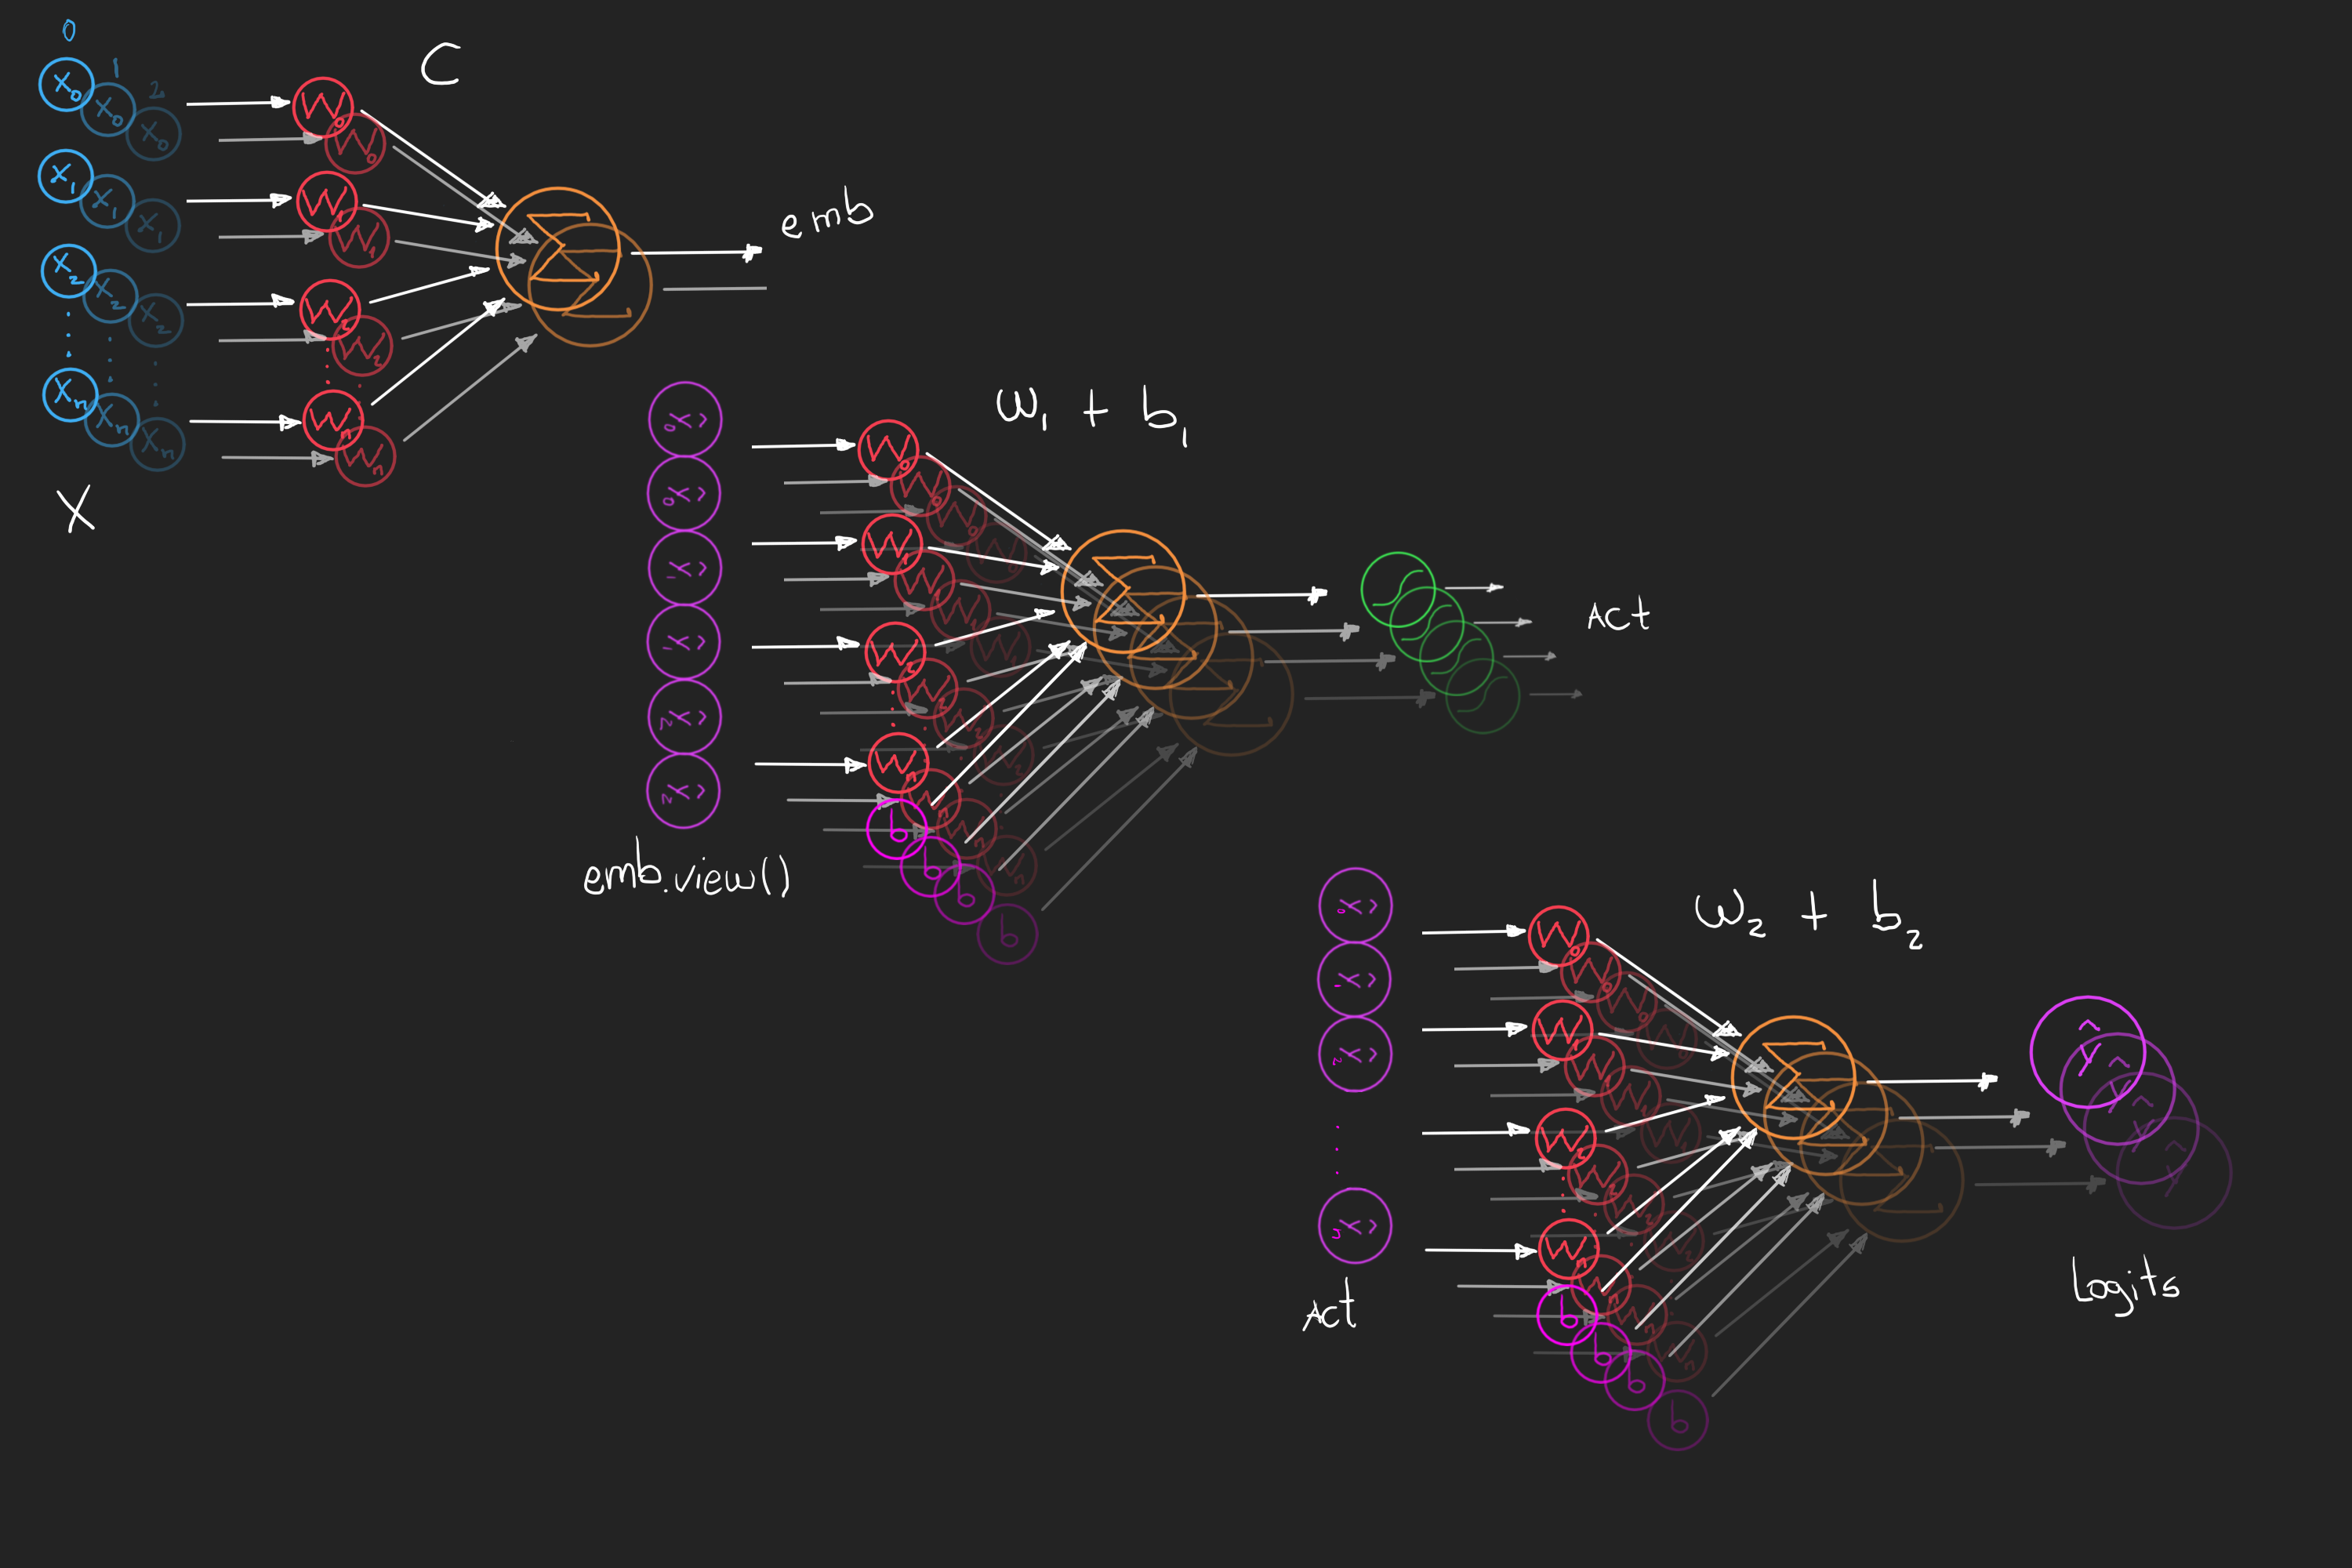

## Implementando el training loop

## F.cross_entropy() y F.Softmax()

# Vuelta a pasar en limpio

In [ ]:
context_size = 3  # El tamaño del contexto o cuantos caracteres vamos a usar para predecir el siguiente
X, Y = [], []

for d in dataset:
    #print(d)
    example = list(d) + ['*']
    context = [0] * context_size
    for c in example:
        #print(''.join([itoc[x] for x in context]) + ' --> ' + c)
        X.append(context)
        Y.append(ctoi[c])
        context = context[1:] + [ctoi[c]]
X = torch.tensor(X)
Y = torch.tensor(Y)
len(X), len(Y)

In [ ]:
class Model:
    def __init__(self, charset_size, context_size, emb_size, hidden_size, g=torch.Generator().manual_seed(42)):
        self.charset_size = charset_size
        self.context_size = context_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.C = torch.randn(self.charset_size, self.emb_size, generator=g)
        self.W1 = torch.randn(self.emb_size*self.context_size, self.hidden_size, generator=g)
        self.b1 = torch.randn(self.hidden_size, generator=g)
        self.W2 = torch.randn(self.hidden_size, self.charset_size, generator=g)
        self.b2 = torch.randn(self.charset_size, generator=g)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = Trued
    
    def __call__(self, x):
        emb = self.C[x]
        act = torch.tanh(emb.view(-1, self.emb_size*self.context_size) @ self.W1 + self.b1)
        logits = act @ self.W2 + self.b2
        return logits


## Visualizando los Embeddings

In [ ]:
C = model.C
plt.figure(figsize=(10,10))
plt.scatter(C[:,0].data, C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color="yellow")

In [ ]:
def build_dataset(dataset: list):
    X, Y  = [], []
    for d in dataset:
        example = list(d) + ['*']
        context = [0] * context_size
        for c in example:
            X.append(context)
            Y.append(ctoi[c])
            context = context[1:] + [ctoi[c]] 
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [ ]:
# build the dataset
context_size = 3
np.random.seed(42)
np.random.shuffle(dataset)
n1 = int(.8 * len(dataset))  # límite para el 80% del dataset
n2 = int(.9 * len(dataset))  # límite para el 90% del dataset
Xtr, Ytr = build_dataset(dataset[:n1])    # 80%
Xva, Yva = build_dataset(dataset[n1:n2])  # 10%
Xte, Yte = build_dataset(dataset[n2:])    # 10%

# Conclusiones
* Hemos cubierto bastante terreno en esta clase!
* Implementamos un modelo a partir del paper que lo describe.
* Introducimos el concepto de Embeddings
  * Mostramos que hay una analogía entre indexing y la multiplicación de one hot vector @ matriz
  * Los embeddings se aprenden y al finalizar el entrenamiento, los caracteres relacionados se agrupan en el espacio
  * Vimos como conectar la capa de embeddings con la capa oculta a pesar de tener diferentes dimensiones de salida/entrada
* Vimos cómo y porqué usar `F.cross_entropy()` y `F.softmax()` en lugar de implementar la funcionalidad a mano
* Hablamos de las ventajas y desventajas de usar entrenamiento por lotes
* Dividimos el dataset en training y testing
* Vimos que es sencillo agrandar el modelo

# Ejercicios
* Agrandar el modelo para que tenga 2 capas hidden de 128 neuronas. (Intermedio)
  * Pista: agregue dos matrices W1.1 y b1.1 entre W1/b1 y W2/b2. Esta nueva capa de neuronas tiene una función de activación `tanh` igual que la primer capa hidden.
* Comparar el resultado de la función de perdida luego de 200K epocas para dos modelos. El primer modelo con una capa hidden de 1024 y el segundo modelo con dos capas hidden de 128. Para ambos modelos, usar un context_size de 4 y un emb_size de 6. (Intermedio)
  * Pista: No necesariamente el modelo más grande (con más parámetros) va a ser mejor. Un modelo más grande puede necesitar más ciclos de entrenamiento, o sencillamente su arquitectura puede no ser lo suficientemente potente como para capturar la complejidad del problema.
  * Nota: Un modelo con context_size de 4 caracteres, sería un modelo de 4-gramas!!
* Si dispone de GPU, averigue como mover los modelos a la memoria de la GPU para relizar el entrenamiento y la inferencia. (Intermedio)
  * Pista: la documentación de torch y `model.to('cuda')`.

## Ejercicios extra
* Entrenar el modelo usando el dataset de nombres de ciudades codificados en PunyCode. (Fácil)
  * Pista: Usar `puny` como dataset, en lugar de `nopuny ` y correr todo de nuevo.
* Escribir una función que reciba una lista de nombres de ciudades. Si el nombre de ciudad empieza con `xn--` asumir que está codificado en PunyCode. La función debe retornar la fración de nombres de ciudades codificados en punycode que pueden decodificarse correctamente. (Fácil)
  * Pista: La función `punydecode` permite decodificar strings normales y strings punicode. Solo falla si el punicode es inválido pero para estring normales, si los caractares son válidos (por ejemplo, el string es todo en minúsculas) no da error. Por ejemplo:

    ```python
    my_puny_checker(['roma', 'xn--pars-xpa', 'atenas', 'xn--'])
    0.5
    ```
    Porque `punydecode` no puede decodificar `xn--`. Las ciudades `roma` y `atenas` no se tienen encuenta en las estadísticas. Vamos a llamar a esta métrica, `fracción puny`.
* Determine la `fracción puny` de los primeros 100 nombres de ciudades generados por el modelo del punto anterior. (Fácil)
* Entrenar un modelo que use ambos datasets, `puny` y `nopuny`. Determine la `fracción puny` de los primeros 100 nombres de ciudades que comiencen con `xn--`. (Fácil)
